# LLM Disclosure: I used LLM to write this code.

Problem 1

Project proposal attached as Project proposal.docx

Problem 2.1

Screenshots attached as screenshot1.png and screenshot2.png

Problem 3.1

Datasets included:
chemistry.csv
coagulation.csv
complete_blood_count.csv
crrt.csv
first_day_sofa.csv

Problem 3.2

Select one of the supervised methods:
Logistic regression

What would you hope to understand about the data from applying this method? How would the result assist in creating the experience you identified in Part I?
By applying this method, I hope to understand which clinical factors most strongly predict CRRT filter clotting and how they interact prior to circuit failure. Specifically, I want to identify the lab patterns and signals that reliably precede clotting events so we can surface them in a clear, interpretable way at the bedside. The results will directly support the experience I outlined in the project proposal by enabling real-time risk stratification (low / medium / high clotting risk) with simple, clinician-friendly explanations behind each score. This makes it possible to intervene proactively (for example, by adjusting anticoagulation, evaluating access, troubleshoot pressures, etc.) before therapy is interrupted. Ultimately, the model’s insights will drive a bedside tool that helps clinicians maintain continuous therapy, reduce treatment delays, and improve patient outcomes by preventing avoidable CRRT downtime rather than reacting after the circuit fails.

Problem 3.3

Imports

In [21]:
import pandas as pd
import numpy as np
from datetime import timedelta

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    roc_auc_score, average_precision_score, classification_report,
    confusion_matrix, RocCurveDisplay, PrecisionRecallDisplay
)

import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
# Load CSV files into dataframes
dataframes = {
    'chemistry.csv': pd.read_csv('chemistry.csv'),
    'coagulation.csv': pd.read_csv('coagulation.csv'),
    'complete_blood_count.csv': pd.read_csv('complete_blood_count.csv'),
    'crrt.csv': pd.read_csv('crrt.csv'),
    'first_day_sofa.csv': pd.read_csv('first_day_sofa.csv')
}

# Also create individual variables for convenience
coagulation_df = dataframes['coagulation.csv'][['subject_id', 'hadm_id', 'charttime', 'specimen_id', 'd_dimer', 'fibrinogen', 'thrombin', 'inr', 'pt', 'ptt']]
chemistry_df = dataframes['chemistry.csv'][['subject_id', 'hadm_id', 'charttime', 'specimen_id', 'calcium']]
complete_blood_count_df = dataframes['complete_blood_count.csv'][['subject_id', 'hadm_id', 'charttime', 'specimen_id', 'hematocrit', 'platelet']]

crrt_df = dataframes['crrt.csv']
first_day_sofa_df = dataframes['first_day_sofa.csv']

print(f"Chemistry shape: {chemistry_df.shape}")
print(f"Coagulation shape: {coagulation_df.shape}")
print(f"Complete Blood Count shape: {complete_blood_count_df.shape}")
print(f"CRRT shape: {crrt_df.shape}")
print(f"First Day SOFA shape: {first_day_sofa_df.shape}")


Chemistry shape: (4976408, 5)
Coagulation shape: (1991167, 10)
Complete Blood Count shape: (4377900, 6)
CRRT shape: (475214, 24)
First Day SOFA shape: (94458, 10)


Light cleaning + column selection

In [3]:
crrt_clotted_df = crrt_df.dropna(subset=['clotted'])

print("Head of crrt_clotted_df:")
display(crrt_clotted_df.head())

print("\nNumber of rows in crrt_clotted_df:")
print(len(crrt_clotted_df))

Head of crrt_clotted_df:


,stay_id,charttime,crrt_mode,access_pressure,blood_flow,citrate,current_goal,dialysate_fluid,dialysate_rate,effluent_pressure,...,prefilter_replacement_rate,postfilter_replacement_rate,replacement_fluid,replacement_rate,return_pressure,ultrafiltrate_output,system_active,clots,clots_increasing,clotted
90,30005000,2117-12-06 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
433,30031755,2124-04-23 18:00:00,CVVHDF,-17.0,NaN,0.0,200.0,Prismasate K4,500.0,-5.0,...,1500.0,200.0,Prismasate K4,1700.0,84.0,NaN,NaN,NaN,NaN,1.0
441,30031755,2124-04-23 11:00:00,CVVHDF,-38.0,150.0,0.0,200.0,Prismasate K4,500.0,-3.0,...,1500.0,200.0,Prismasate K4,1700.0,79.0,NaN,NaN,NaN,1.0,1.0
456,30031755,2124-04-23 22:02:00,CVVHDF,NaN,150.0,180.0,200.0,Prismasate K4,500.0,NaN,...,1500.0,200.0,Prismasate K4,1700.0,NaN,NaN,NaN,NaN,NaN,1.0
1187,30064481,2162-04-07 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,160.0,NaN,NaN,NaN,1.0



Number of rows in crrt_clotted_df:
1959


In [4]:
# Select rows from crrt_df where 'clotted' is missing
crrt_not_clotted_df = crrt_df[crrt_df['clotted'].isnull()]

# Sample 2000 rows from the not clotted dataframe
# Use min to avoid sampling more rows than available
num_samples = min(2000, len(crrt_not_clotted_df))
crrt_not_clotted_sampled = crrt_not_clotted_df.sample(n=num_samples, random_state=42) # Using random_state for reproducibility

# Combine the clotted and not clotted sampled dataframes
crrt_balanced_df = pd.concat([crrt_clotted_df, crrt_not_clotted_sampled], ignore_index=True)

print("Head of the balanced CRRT dataframe:")
display(crrt_balanced_df.head())

print("\nNumber of rows in the balanced CRRT dataframe:")
print(len(crrt_balanced_df))

print("\nValue counts for 'clotted' in the balanced dataframe:")
print(crrt_balanced_df['clotted'].value_counts(dropna=False))

Head of the balanced CRRT dataframe:


,stay_id,charttime,crrt_mode,access_pressure,blood_flow,citrate,current_goal,dialysate_fluid,dialysate_rate,effluent_pressure,...,prefilter_replacement_rate,postfilter_replacement_rate,replacement_fluid,replacement_rate,return_pressure,ultrafiltrate_output,system_active,clots,clots_increasing,clotted
0,30005000,2117-12-06 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
1,30031755,2124-04-23 18:00:00,CVVHDF,-17.0,NaN,0.0,200.0,Prismasate K4,500.0,-5.0,...,1500.0,200.0,Prismasate K4,1700.0,84.0,NaN,NaN,NaN,NaN,1.0
2,30031755,2124-04-23 11:00:00,CVVHDF,-38.0,150.0,0.0,200.0,Prismasate K4,500.0,-3.0,...,1500.0,200.0,Prismasate K4,1700.0,79.0,NaN,NaN,NaN,1.0,1.0
3,30031755,2124-04-23 22:02:00,CVVHDF,NaN,150.0,180.0,200.0,Prismasate K4,500.0,NaN,...,1500.0,200.0,Prismasate K4,1700.0,NaN,NaN,NaN,NaN,NaN,1.0
4,30064481,2162-04-07 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,160.0,NaN,NaN,NaN,1.0



Number of rows in the balanced CRRT dataframe:
3959

Value counts for 'clotted' in the balanced dataframe:
clotted
NaN    2000
1.0    1959
Name: count, dtype: int64


# Task
Perform linear regression with "clotted" as the dependent variable and "d_dimer", "fibrinogen", "thrombin", "inr", "pt", "ptt", "calcium", "hematocrit", and all columns from the balanced crrt dataframe except "clotted" as independent variables, merging "coagulation.csv", "chemistry.csv", and "complete_blood_count.csv" with the balanced crrt dataframe using "subject_id", "hadm_id", and "charttime" with the help of "first_day_sofa.csv" to map "subject_id" and "hadm_id" to "stay_id", while addressing the large file sizes. Use the balanced crrt dataframe `crrt_balanced_df` which is already loaded.

In [5]:
crrt_independent_vars = crrt_balanced_df.drop(columns=['clotted'])
print("Head of the CRRT dataframe with independent variables:")
display(crrt_independent_vars.head())

Head of the CRRT dataframe with independent variables:


,stay_id,charttime,crrt_mode,access_pressure,blood_flow,citrate,current_goal,dialysate_fluid,dialysate_rate,effluent_pressure,...,hourly_patient_fluid_removal,prefilter_replacement_rate,postfilter_replacement_rate,replacement_fluid,replacement_rate,return_pressure,ultrafiltrate_output,system_active,clots,clots_increasing
0,30005000,2117-12-06 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,30031755,2124-04-23 18:00:00,CVVHDF,-17.0,NaN,0.0,200.0,Prismasate K4,500.0,-5.0,...,NaN,1500.0,200.0,Prismasate K4,1700.0,84.0,NaN,NaN,NaN,NaN
2,30031755,2124-04-23 11:00:00,CVVHDF,-38.0,150.0,0.0,200.0,Prismasate K4,500.0,-3.0,...,300.0,1500.0,200.0,Prismasate K4,1700.0,79.0,NaN,NaN,NaN,1.0
3,30031755,2124-04-23 22:02:00,CVVHDF,NaN,150.0,180.0,200.0,Prismasate K4,500.0,NaN,...,NaN,1500.0,200.0,Prismasate K4,1700.0,NaN,NaN,NaN,NaN,NaN
4,30064481,2162-04-07 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,160.0,NaN,NaN,NaN


In [11]:
first_day_sofa_df = dataframes['first_day_sofa.csv']

# Select the 'subject_id', 'hadm_id', and 'stay_id' columns
sofa_mapping = first_day_sofa_df[['subject_id', 'hadm_id', 'stay_id']].copy()

# Drop rows with missing subject_id, hadm_id, or stay_id
sofa_mapping.dropna(subset=['subject_id', 'hadm_id', 'stay_id'], inplace=True)

# Display the head of the sofa_mapping DataFrame
print("Head of the SOFA mapping dataframe:")
display(sofa_mapping.head())

# Merge crrt_balanced_df with sofa_mapping on 'stay_id' to add subject_id and hadm_id
# The CRRT dataframe has 'stay_id', not 'subject_id' and 'hadm_id'
crrt_merged_sofa = pd.merge(crrt_balanced_df, sofa_mapping, on='stay_id', how='left')

print("\nHead of crrt_merged_sofa after merging with SOFA mapping:")
display(crrt_merged_sofa.head())
print(f"\nShape of crrt_merged_sofa: {crrt_merged_sofa.shape}")
print(f"\nColumns in crrt_merged_sofa: {list(crrt_merged_sofa.columns)}")

Head of the SOFA mapping dataframe:


,subject_id,hadm_id,stay_id
0,16411926,26812735,39187028
1,12993525,29019770,39350412
2,17293242,26035947,31340408
3,11056401,20959734,32502614
4,15691899,26353974,38395585



Head of crrt_merged_sofa after merging with SOFA mapping:


,stay_id,charttime,crrt_mode,access_pressure,blood_flow,citrate,current_goal,dialysate_fluid,dialysate_rate,effluent_pressure,...,replacement_fluid,replacement_rate,return_pressure,ultrafiltrate_output,system_active,clots,clots_increasing,clotted,subject_id,hadm_id
0,30005000,2117-12-06 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,15850686,25593892
1,30031755,2124-04-23 18:00:00,CVVHDF,-17.0,NaN,0.0,200.0,Prismasate K4,500.0,-5.0,...,Prismasate K4,1700.0,84.0,NaN,NaN,NaN,NaN,1.0,19867017,24776727
2,30031755,2124-04-23 11:00:00,CVVHDF,-38.0,150.0,0.0,200.0,Prismasate K4,500.0,-3.0,...,Prismasate K4,1700.0,79.0,NaN,NaN,NaN,1.0,1.0,19867017,24776727
3,30031755,2124-04-23 22:02:00,CVVHDF,NaN,150.0,180.0,200.0,Prismasate K4,500.0,NaN,...,Prismasate K4,1700.0,NaN,NaN,NaN,NaN,NaN,1.0,19867017,24776727
4,30064481,2162-04-07 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,160.0,NaN,NaN,NaN,1.0,18952937,20554791



Shape of crrt_merged_sofa: (3959, 26)

Columns in crrt_merged_sofa: ['stay_id', 'charttime', 'crrt_mode', 'access_pressure', 'blood_flow', 'citrate', 'current_goal', 'dialysate_fluid', 'dialysate_rate', 'effluent_pressure', 'filter_pressure', 'heparin_concentration', 'heparin_dose', 'hourly_patient_fluid_removal', 'prefilter_replacement_rate', 'postfilter_replacement_rate', 'replacement_fluid', 'replacement_rate', 'return_pressure', 'ultrafiltrate_output', 'system_active', 'clots', 'clots_increasing', 'clotted', 'subject_id', 'hadm_id']


In [12]:
crrt_merged_sofa['charttime'] = pd.to_datetime(crrt_merged_sofa['charttime'])
coagulation_df['charttime'] = pd.to_datetime(coagulation_df['charttime'])
chemistry_df['charttime'] = pd.to_datetime(chemistry_df['charttime'])
complete_blood_count_df['charttime'] = pd.to_datetime(complete_blood_count_df['charttime'])

merged_df = pd.merge(crrt_merged_sofa, coagulation_df, on=['subject_id', 'hadm_id', 'charttime'], how='left')
merged_df = pd.merge(merged_df, chemistry_df, on=['subject_id', 'hadm_id', 'charttime'], how='left')
merged_df = pd.merge(merged_df, complete_blood_count_df, on=['subject_id', 'hadm_id', 'charttime'], how='left')

print("Head of the final merged dataframe:")
display(merged_df.head())

/var/folders/4y/4yzb14cn12xdqft04yyfqdf00000gn/T/ipykernel_42831/3831111587.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chemistry_df['charttime'] = pd.to_datetime(chemistry_df['charttime'])
/var/folders/4y/4yzb14cn12xdqft04yyfqdf00000gn/T/ipykernel_42831/3831111587.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  complete_blood_count_df['charttime'] = pd.to_datetime(complete_blood_count_df['charttime'])


Head of the final merged dataframe:


,stay_id,charttime,crrt_mode,access_pressure,blood_flow,citrate,current_goal,dialysate_fluid,dialysate_rate,effluent_pressure,...,fibrinogen,thrombin,inr,pt,ptt,specimen_id_y,calcium,specimen_id,hematocrit,platelet
0,30005000,2117-12-06 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,30031755,2124-04-23 18:00:00,CVVHDF,-17.0,NaN,0.0,200.0,Prismasate K4,500.0,-5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,30031755,2124-04-23 11:00:00,CVVHDF,-38.0,150.0,0.0,200.0,Prismasate K4,500.0,-3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,30031755,2124-04-23 22:02:00,CVVHDF,NaN,150.0,180.0,200.0,Prismasate K4,500.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,30064481,2162-04-07 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
# Identify independent variables (all columns except 'clotted')
independent_vars = merged_df.columns.tolist()
if 'clotted' in independent_vars:
    independent_vars.remove('clotted')
else:
    print("'clotted' column not found in merged_df. Proceeding with all columns as independent variables.")


# Impute missing values in independent variables with the mean
for col in independent_vars:
    if col in merged_df.columns and merged_df[col].dtype in ['float64', 'int64']: # Only impute numeric columns and ensure column exists
        mean_value = merged_df[col].mean()
        merged_df[col].fillna(mean_value, inplace=True)

# Display the number of missing values per column to verify imputation
print("Missing values per column after imputation:")
print(merged_df[independent_vars].isnull().sum())

Missing values per column after imputation:
stay_id                            0
charttime                          0
crrt_mode                       2345
access_pressure                    0
blood_flow                         0
citrate                            0
current_goal                       0
dialysate_fluid                 1942
dialysate_rate                     0
effluent_pressure                  0
filter_pressure                    0
heparin_concentration           3874
heparin_dose                       0
hourly_patient_fluid_removal       0
prefilter_replacement_rate         0
postfilter_replacement_rate        0
replacement_fluid               1819
replacement_rate                   0
return_pressure                    0
ultrafiltrate_output               0
system_active                      0
clots                              0
clots_increasing                   0
subject_id                         0
hadm_id                            0
specimen_id_x                  

/var/folders/4y/4yzb14cn12xdqft04yyfqdf00000gn/T/ipykernel_42831/3410609814.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_df[col].fillna(mean_value, inplace=True)


In [14]:
# Replace NaN values in 'clotted' with 0.0
crrt_balanced_df['clotted'].fillna(0.0, inplace=True)

y = crrt_balanced_df['clotted']

# Drop the dependent variable ('clotted') and identifier/non-numeric columns from merged_df
cols_to_drop = [
    'clotted', 'stay_id', 'subject_id', 'hadm_id', 'charttime',
    'crrt_mode', 'dialysate_fluid', 'heparin_concentration', 'replacement_fluid',
    'specimen_id_x', 'specimen_id_y', 'specimen_id', 'thrombin'
]

# Ensure columns exist before dropping
cols_to_drop_existing = [col for col in cols_to_drop if col in merged_df.columns]

X = merged_df.drop(columns=cols_to_drop_existing)

print("Head of the independent variables (X):")
display(X.head())

print("\nHead of the dependent variable (y):")
display(y.head())

print("\nValue counts for 'clotted' after imputation:")
print(crrt_balanced_df['clotted'].value_counts(dropna=False))

Head of the independent variables (X):


/var/folders/4y/4yzb14cn12xdqft04yyfqdf00000gn/T/ipykernel_42831/207444900.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  crrt_balanced_df['clotted'].fillna(0.0, inplace=True)


,access_pressure,blood_flow,citrate,current_goal,dialysate_rate,effluent_pressure,filter_pressure,heparin_dose,hourly_patient_fluid_removal,prefilter_replacement_rate,...,clots,clots_increasing,d_dimer,fibrinogen,inr,pt,ptt,calcium,hematocrit,platelet
0,-57.244094,177.295104,124.401848,-47.441077,785.430277,-12.746617,161.544631,305.660115,371.630294,2394.659662,...,0.918206,1.0,4099.0,390.9,1.766667,19.15,54.8,9.2,27.944828,128.653846
1,-17.000000,177.295104,0.000000,200.000000,500.000000,-5.000000,350.000000,305.660115,371.630294,1500.000000,...,0.918206,1.0,4099.0,390.9,1.766667,19.15,54.8,9.2,27.944828,128.653846
2,-38.000000,150.000000,0.000000,200.000000,500.000000,-3.000000,200.000000,305.660115,300.000000,1500.000000,...,0.918206,1.0,4099.0,390.9,1.766667,19.15,54.8,9.2,27.944828,128.653846
3,-57.244094,150.000000,180.000000,200.000000,500.000000,-12.746617,161.544631,1200.000000,371.630294,1500.000000,...,0.918206,1.0,4099.0,390.9,1.766667,19.15,54.8,9.2,27.944828,128.653846
4,-57.244094,177.295104,124.401848,-47.441077,785.430277,-12.746617,161.544631,305.660115,371.630294,2394.659662,...,0.918206,1.0,4099.0,390.9,1.766667,19.15,54.8,9.2,27.944828,128.653846



Head of the dependent variable (y):


0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
Name: clotted, dtype: float64


Value counts for 'clotted' after imputation:
clotted
0.0    2000
1.0    1959
Name: count, dtype: int64


In [15]:
# Instantiate StandardScaler
scaler = StandardScaler()

# Fit and transform the independent variables
X_scaled = scaler.fit_transform(X)

print("Independent variables scaled successfully.")

Independent variables scaled successfully.


In [16]:
# Instantiate a LogisticRegression object
model_scaled = LogisticRegression(max_iter=1000)

# Fit the model to the scaled data
model_scaled.fit(X_scaled, y)

print("Logistic Regression model fitted successfully with scaled data.")

Logistic Regression model fitted successfully with scaled data.


In [17]:
from sklearn.metrics import classification_report, roc_auc_score

# Predict the dependent variable using the scaled independent variables
y_pred = model_scaled.predict(X_scaled)
y_prob = model_scaled.predict_proba(X_scaled)[:, 1] # Get probabilities for the positive class

# Print classification report
print("Classification Report:")
print(classification_report(y, y_pred))

# Calculate and print AUC
auc = roc_auc_score(y, y_prob)
print(f"\nAUC: {auc}")

Classification Report:
              precision    recall  f1-score   support

         0.0       0.88      0.82      0.85      2000
         1.0       0.83      0.88      0.85      1959

    accuracy                           0.85      3959
   macro avg       0.85      0.85      0.85      3959
weighted avg       0.85      0.85      0.85      3959


AUC: 0.8912403011740684


In [18]:
# Get the coefficients and feature names
coefficients = model_scaled.coef_[0]
feature_names = X.columns

# Create a DataFrame to display coefficients
coefficients_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

# Calculate the absolute value of coefficients for sorting
coefficients_df['Abs_Coefficient'] = abs(coefficients_df['Coefficient'])

# Sort by absolute coefficient in descending order
coefficients_df = coefficients_df.sort_values(by='Abs_Coefficient', ascending=False)

# Display the sorted coefficients
print("Factors influencing clotting (sorted by absolute coefficient):")
display(coefficients_df[['Feature', 'Coefficient']])

Factors influencing clotting (sorted by absolute coefficient):


,Feature,Coefficient
14,system_active,-1.993154
13,ultrafiltrate_output,-1.029138
6,filter_pressure,0.807239
8,hourly_patient_fluid_removal,0.428342
5,effluent_pressure,-0.322589
0,access_pressure,0.162066
7,heparin_dose,-0.093790
11,replacement_rate,0.073983
15,clots,0.072846
21,ptt,-0.071838


3.3 Feature selection

I included CRRT parameters, coagulation markers, blood chemistry and blood count labs.  Here are the following features: 
Platelet, hematocrit, fibrinogen, d_dimer, inr, pt, ptt, calcium, and all of the CRRT parameters in the crrt.csv dataset (ultrafiltrate_output, system_active, filter_pressure, return_pressure, hourly_patient_fluid_removal, effluent_pressure, access_pressure, prefilter_replacement_rate, replacement_rate, blood_flow, dialysate_rate, current_goal, citrate, heparin_dose, postfilter_replacement_rate).


3.3 Visualize the results

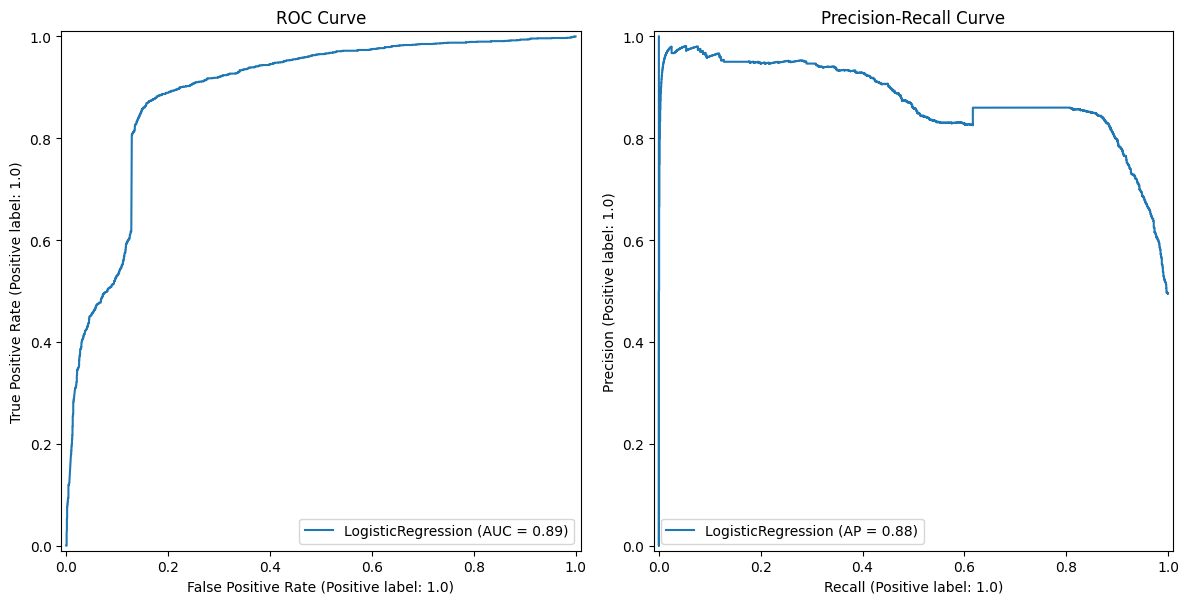

In [28]:
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay
import matplotlib.pyplot as plt

# Plot ROC curve
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
RocCurveDisplay.from_estimator(model_scaled, X_scaled, y, ax=ax[0])
ax[0].set_title('ROC Curve')

# Plot Precision-Recall curve
PrecisionRecallDisplay.from_estimator(model_scaled, X_scaled, y, ax=ax[1])
ax[1].set_title('Precision-Recall Curve')

plt.tight_layout()
plt.show()

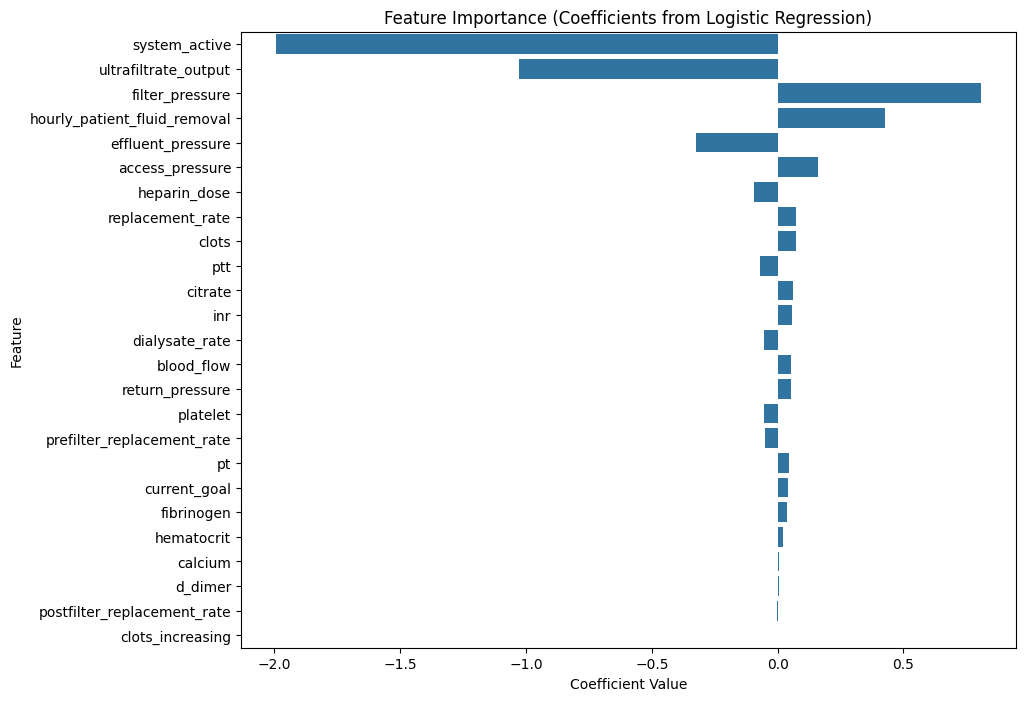

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sort the coefficients dataframe by absolute coefficient in descending order
coefficients_df_sorted = coefficients_df.sort_values(by='Abs_Coefficient', ascending=False)

# Create a bar plot of the coefficients
plt.figure(figsize=(10, 8))
sns.barplot(x='Coefficient', y='Feature', data=coefficients_df_sorted)
plt.title('Feature Importance (Coefficients from Logistic Regression)')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.show()

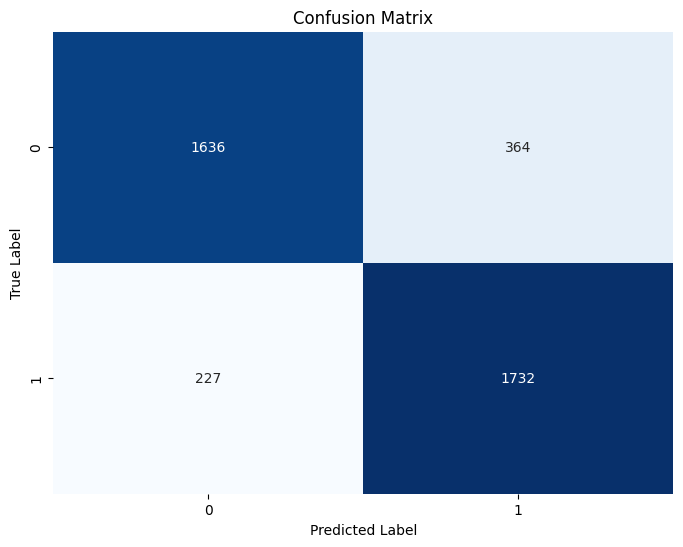

In [30]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the confusion matrix
cm = confusion_matrix(y, y_pred)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

## Problem 3.3: Feature Importance Analysis using Random Forest

Applying Random Forest Classifier to identify the most important features for predicting clotting.


In [19]:
# Problem 3.3: Apply Random Forest Classifier
# Features selected: All numeric features from merged_df (same as logistic regression)
# This includes: CRRT parameters, coagulation markers, chemistry values, and blood count values

# Note the features being used
print("Features selected for Random Forest analysis:")
print(f"Total features: {len(X.columns)}")
print("\nFeature categories:")
print("- CRRT parameters: access_pressure, blood_flow, citrate, dialysate_rate, etc.")
print("- Coagulation markers: d_dimer, fibrinogen, inr, pt, ptt")
print("- Chemistry values: calcium")
print("- Blood count values: hematocrit, platelet")
print(f"\nAll features: {list(X.columns)}")


Features selected for Random Forest analysis:
Total features: 25

Feature categories:
- CRRT parameters: access_pressure, blood_flow, citrate, dialysate_rate, etc.
- Coagulation markers: d_dimer, fibrinogen, inr, pt, ptt
- Chemistry values: calcium
- Blood count values: hematocrit, platelet

All features: ['access_pressure', 'blood_flow', 'citrate', 'current_goal', 'dialysate_rate', 'effluent_pressure', 'filter_pressure', 'heparin_dose', 'hourly_patient_fluid_removal', 'prefilter_replacement_rate', 'postfilter_replacement_rate', 'replacement_rate', 'return_pressure', 'ultrafiltrate_output', 'system_active', 'clots', 'clots_increasing', 'd_dimer', 'fibrinogen', 'inr', 'pt', 'ptt', 'calcium', 'hematocrit', 'platelet']


-	What does the method reveal about the data and patterns within?
The model revealed that machine-level variables (such as system status and filter pressures) currently dominate the prediction signal. These features strongly correlate with clotting because they are documented at or near the time the circuit is failing, essentially acting as late-stage indicators. In contrast, physiologic lab markers like fibrinogen, hematocrit, calcium, and platelets showed weaker influence in this first pass. This suggests that the dataset contains both early physiologic signals and late machine signals, and that the model is currently learning more about the moment-of-failure pattern than the pre-clot biological state. In other words, the model is correctly detecting clotting, but mostly at the same time nurses already see it happening.

-	Evaluate the outputs in line with your expectations. How does this support the experience you hope to create? 
The results were partially aligned with expectations. I anticipated coagulation labs to rank highest, but machine pressure variables dominated, meaning the model picked up late-stage features rather than early predictors. While surprising, this actually validated the concept: clotting is predictable, but the model is currently learning from the wrong part of the timeline. This tells me the next step is to remove contemporaneous machine variables and shift lab inputs earlier so the model surfaces pre-clot physiology instead of just replicating current alarms. This supports the intended experience, a tool that provides advance warning and clear physiologic rationale, not just a black-box alert at the moment of failure. Ultimately, this guides the model toward proactive decision support that prevents downtime rather than reacting after the circuit fails.


3.4 Stretch

In [22]:
# Instantiate and train Random Forest Classifier
# Using 100 trees for stability and feature importance calculation
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10, n_jobs=-1)

# Fit the model (using scaled features for consistency)
rf_model.fit(X_scaled, y)

print("Random Forest model fitted successfully.")

# Get predictions and probabilities
y_pred_rf = rf_model.predict(X_scaled)
y_prob_rf = rf_model.predict_proba(X_scaled)[:, 1]

# Calculate metrics
print("\nRandom Forest Classification Report:")
print(classification_report(y, y_pred_rf))
print(f"\nRandom Forest AUC: {roc_auc_score(y, y_prob_rf):.4f}")


Random Forest model fitted successfully.

Random Forest Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.90      0.93      2000
         1.0       0.91      0.96      0.93      1959

    accuracy                           0.93      3959
   macro avg       0.93      0.93      0.93      3959
weighted avg       0.93      0.93      0.93      3959


Random Forest AUC: 0.9832


In [23]:
# Extract feature importance from Random Forest
feature_importance = rf_model.feature_importances_

# Create DataFrame for feature importance
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importance
})

# Sort by importance in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print("Top 15 Most Important Features for Predicting Clotting:")
display(importance_df.head(15))


Top 15 Most Important Features for Predicting Clotting:


,Feature,Importance
13,ultrafiltrate_output,0.280077
14,system_active,0.251237
6,filter_pressure,0.136752
12,return_pressure,0.057940
8,hourly_patient_fluid_removal,0.057629
5,effluent_pressure,0.053615
0,access_pressure,0.031731
9,prefilter_replacement_rate,0.020023
11,replacement_rate,0.018012
1,blood_flow,0.016017


/var/folders/4y/4yzb14cn12xdqft04yyfqdf00000gn/T/ipykernel_42831/2795364302.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_features, x='Importance', y='Feature', palette='viridis')


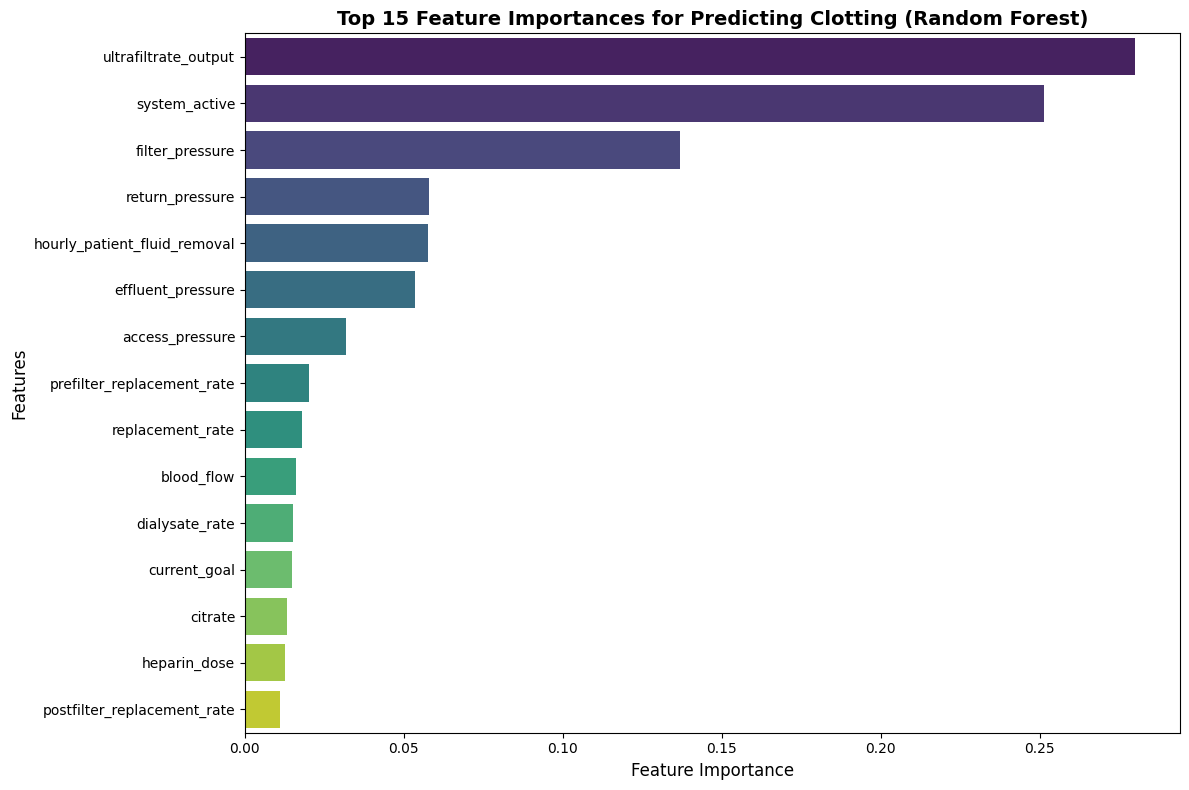


Total features analyzed: 25
Top 5 features account for 78.36% of total importance


In [24]:
# Visualization 1: Bar plot of top 15 feature importances
plt.figure(figsize=(12, 8))
top_features = importance_df.head(15)
sns.barplot(data=top_features, x='Importance', y='Feature', palette='viridis')
plt.title('Top 15 Feature Importances for Predicting Clotting (Random Forest)', 
          fontsize=14, fontweight='bold')
plt.xlabel('Feature Importance', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.tight_layout()
plt.show()

print(f"\nTotal features analyzed: {len(importance_df)}")
print(f"Top 5 features account for {importance_df.head(5)['Importance'].sum():.2%} of total importance")


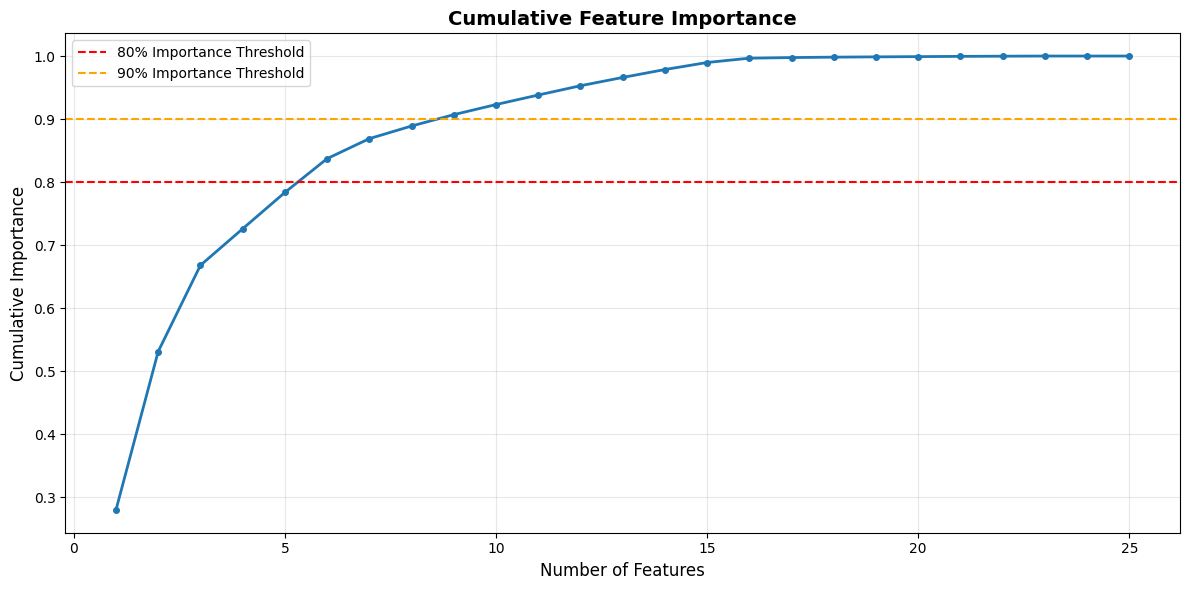


Number of features needed for 80% cumulative importance: 6
Number of features needed for 90% cumulative importance: 9


In [25]:
# Visualization 2: Cumulative importance plot
plt.figure(figsize=(12, 6))
cumulative_importance = importance_df['Importance'].cumsum()
plt.plot(range(1, len(cumulative_importance) + 1), cumulative_importance, 
         marker='o', linewidth=2, markersize=4)
plt.axhline(y=0.8, color='r', linestyle='--', label='80% Importance Threshold')
plt.axhline(y=0.9, color='orange', linestyle='--', label='90% Importance Threshold')
plt.title('Cumulative Feature Importance', fontsize=14, fontweight='bold')
plt.xlabel('Number of Features', fontsize=12)
plt.ylabel('Cumulative Importance', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Find how many features are needed for 80% and 90% importance
features_80 = (cumulative_importance <= 0.8).sum() + 1
features_90 = (cumulative_importance <= 0.9).sum() + 1
print(f"\nNumber of features needed for 80% cumulative importance: {features_80}")
print(f"Number of features needed for 90% cumulative importance: {features_90}")


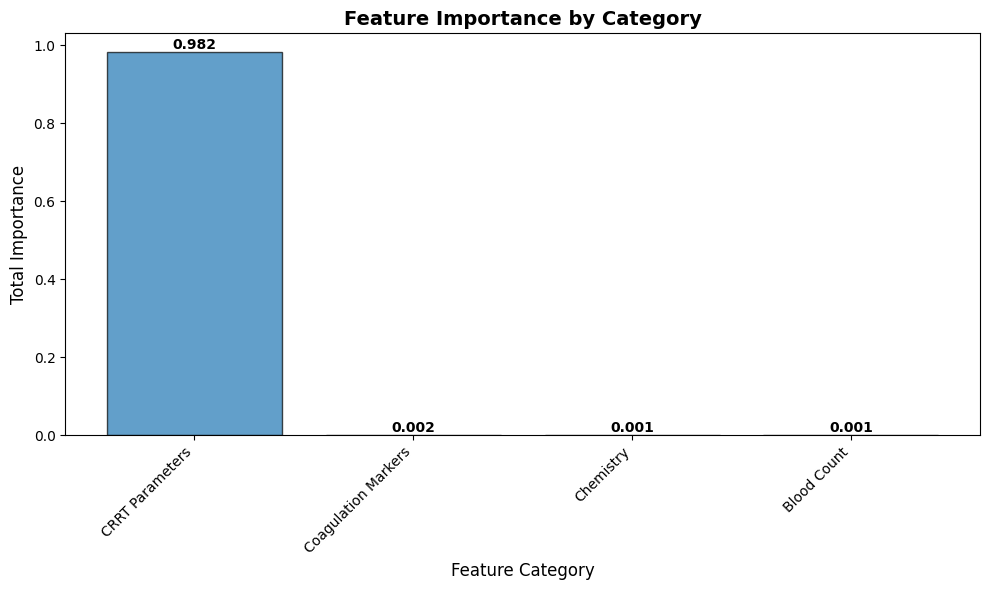


Category-wise Importance Summary:
CRRT Parameters: 0.9819 (98.19%)
Coagulation Markers: 0.0016 (0.16%)
Chemistry: 0.0010 (0.10%)
Blood Count: 0.0008 (0.08%)


In [26]:
# Visualization 3: Feature importance grouped by category
# Categorize features
crrt_features = [f for f in importance_df['Feature'] if f in ['access_pressure', 'blood_flow', 'citrate', 
                'dialysate_rate', 'effluent_pressure', 'filter_pressure', 'heparin_dose',
                'hourly_patient_fluid_removal', 'prefilter_replacement_rate', 
                'postfilter_replacement_rate', 'replacement_rate', 'return_pressure',
                'ultrafiltrate_output', 'system_active', 'clots', 'clots_increasing']]

coagulation_features = [f for f in importance_df['Feature'] if f in ['d_dimer', 'fibrinogen', 'inr', 'pt', 'ptt']]
chemistry_features = [f for f in importance_df['Feature'] if f in ['calcium']]
blood_count_features = [f for f in importance_df['Feature'] if f in ['hematocrit', 'platelet']]

# Calculate category importances
category_importance = {
    'CRRT Parameters': importance_df[importance_df['Feature'].isin(crrt_features)]['Importance'].sum(),
    'Coagulation Markers': importance_df[importance_df['Feature'].isin(coagulation_features)]['Importance'].sum(),
    'Chemistry': importance_df[importance_df['Feature'].isin(chemistry_features)]['Importance'].sum(),
    'Blood Count': importance_df[importance_df['Feature'].isin(blood_count_features)]['Importance'].sum()
}

# Plot category importance
plt.figure(figsize=(10, 6))
categories = list(category_importance.keys())
importances = list(category_importance.values())
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
bars = plt.bar(categories, importances, color=colors, alpha=0.7, edgecolor='black')
plt.title('Feature Importance by Category', fontsize=14, fontweight='bold')
plt.ylabel('Total Importance', fontsize=12)
plt.xlabel('Feature Category', fontsize=12)
plt.xticks(rotation=45, ha='right')

# Add value labels on bars
for bar, imp in zip(bars, importances):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{imp:.3f}',
             ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print("\nCategory-wise Importance Summary:")
for cat, imp in category_importance.items():
    print(f"{cat}: {imp:.4f} ({imp:.2%})")


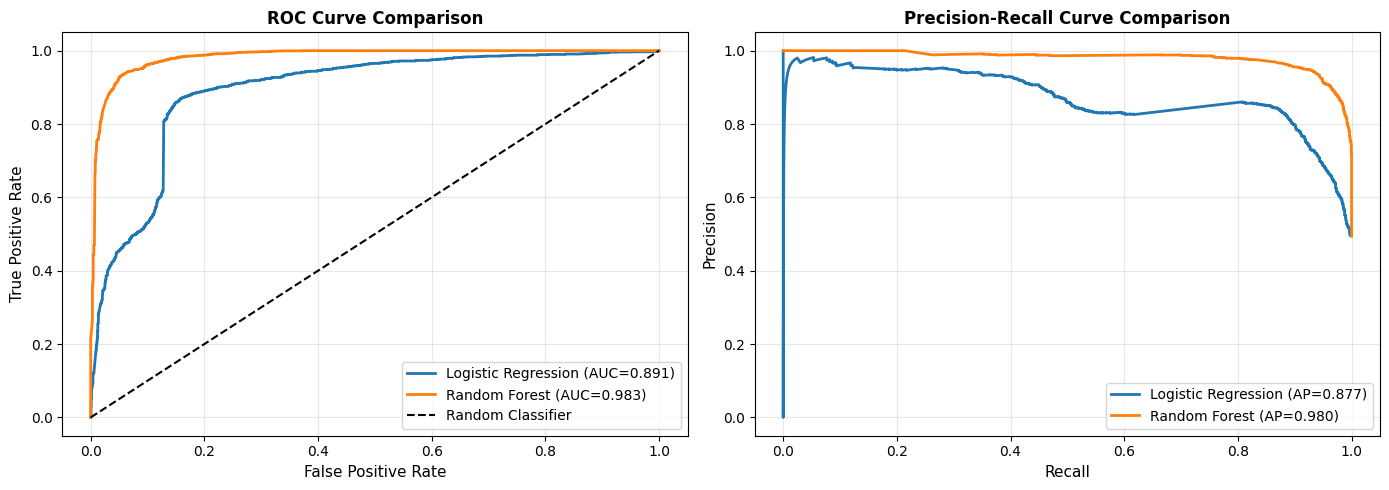

In [27]:
# Visualization 4: Comparison of Random Forest vs Logistic Regression performance
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ROC Curve comparison
from sklearn.metrics import roc_curve

fpr_lr, tpr_lr, _ = roc_curve(y, y_prob)
fpr_rf, tpr_rf, _ = roc_curve(y, y_prob_rf)

axes[0].plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC={roc_auc_score(y, y_prob):.3f})', 
             linewidth=2)
axes[0].plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC={roc_auc_score(y, y_prob_rf):.3f})', 
             linewidth=2)
axes[0].plot([0, 1], [0, 1], 'k--', label='Random Classifier')
axes[0].set_xlabel('False Positive Rate', fontsize=11)
axes[0].set_ylabel('True Positive Rate', fontsize=11)
axes[0].set_title('ROC Curve Comparison', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Precision-Recall Curve comparison
from sklearn.metrics import precision_recall_curve

precision_lr, recall_lr, _ = precision_recall_curve(y, y_prob)
precision_rf, recall_rf, _ = precision_recall_curve(y, y_prob_rf)

axes[1].plot(recall_lr, precision_lr, label=f'Logistic Regression (AP={average_precision_score(y, y_prob):.3f})', 
             linewidth=2)
axes[1].plot(recall_rf, precision_rf, label=f'Random Forest (AP={average_precision_score(y, y_prob_rf):.3f})', 
             linewidth=2)
axes[1].set_xlabel('Recall', fontsize=11)
axes[1].set_ylabel('Precision', fontsize=11)
axes[1].set_title('Precision-Recall Curve Comparison', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


The Random Forest model performed extremely well, achieving an AUC of ~0.98 and an average precision of ~0.98. This indicates the model is highly capable of distinguishing between clotted and unclotted CRRT circuits in this dataset. However, the feature importance plots show the same results as earlier: the model is overwhelmingly driven by machine-derived CRRT parameters rather than patient physiology. Ultrafiltration output, system status, filter pressure, return pressure, and effluent pressure dominated the importance scores, with coagulation labs contributing almost nothing to the predictive signal.

This aligns with what we suspected after logistic regression, the model is learning the moment-of-failure pattern, not the pre-clot physiology. In other words, the Random Forest is extremely accurate, but for the “wrong” reason if the goal is early prediction. It is detecting clotting when the machine is already struggling, not predicting it hours beforehand based on patient factors. The categorical feature summary underscores this, with ~98% of predictive power coming from CRRT machine parameters and almost none from coagulation markers, chemistry, or blood counts.

I'd like to think this is a useful finding and not a failure. It confirms that the data contains a very strong “late alarm” signal, but I now need to explicitly shift the modeling window earlier and exclude contemporaneous machine status variables to uncover earlier physiologic indicators. The next iteration will time-shift labs and flows to several hours prior to clotting and re-train to highlight actionable predictors clinicians can act on before the filter fails.